In [1]:
from collections import defaultdict
from typing import Dict
from pathlib import Path
from IPython.display import display
import pandas as pd
import numpy as np
from ase.visualize import view
from pymatgen.io.ase import AseAtomsAdaptor
import matplotlib.pyplot as plt
from pymatgen.core import Structure, Lattice
from pymatgen.util.coord import *
from pymatgen.core.periodic_table import Element, ElementBase, DummySpecie
from copy import deepcopy
import matplotlib.patches as mpatches

/home/azizr/anaconda3/envs/ai4mat/lib/python3.10/site-packages/pymatgen/core/__init__.py:49: UserWarning: Error loading .pmgrc.yaml: [Errno 2] No such file or directory: '/home/azizr/.pmgrc.yaml'. You may need to reconfigure your yaml file.
  warnings.warn(f"Error loading .pmgrc.yaml: {ex}. You may need to reconfigure your yaml file.")


In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [6]:
data = pd.read_pickle('../datasets/processed/dichalcogenides_x1s6_202109_MoS2/data.pickle.gz')

In [7]:
plotter = lambda s: view(AseAtomsAdaptor().get_atoms(s), viewer='ngl')

In [8]:
def get_pristine_lattice(struct, defect_rep):
    """ Get a lattice without defects 
    """
    struct = deepcopy(struct)
    replace_dict = {}
    for atom in defect_rep:
        was = ElementBase.from_Z(atom.properties['was'])
        # The element type in sparse representaion is compound thus we need to make it an element
        current = atom.species.elements[0]
        if current == DummySpecie():
            struct.append(was, atom.coords, coords_are_cartesian=True)
        else:
            replace_dict[current] = was
    # inplace operation hence the deepcopy above
    struct.replace_species(replace_dict)
    return struct


def update_properties(site, eos_idx, distance_idx):
    site.properties['eos_idx'] = eos_idx
    site.properties['distance_idx'] = distance_idx
    return site

def get_struct_plane(struct):
    # Z axis
    Z = struct.cart_coords[:, 2]
    # cluster the Z axis with 3 bins hist
    _, edges = np.histogram(Z, bins=2)
    return np.sort(edges)

def get_plane_idx(planes, atom):
    return np.argmin(np.abs(planes - atom.z))


def remove_close_values(arr, tol=0.5):
    """ Remove elements in the array that have difference less than the provided tolerence
    """
    arr.sort()
    diff = np.diff(arr, n=1, prepend=0) 
    return arr[diff > tol]


def get_shell_r(struct, center_idx, atom_type, max_r=10):
    """
    Get all the atoms that lay on the circumference of a shell of radius r
    - struct: a pymatgen structure
    - center_idx: the index of the center atom
    """
    
    _struct = Structure.from_sites([atom for atom in struct if atom.species_string == atom_type])
    shells = []
    for site in _struct:
        # if (site.species_string == atom_type):
        shells.append(site.distance(struct[center_idx]))
    shells = np.unique(np.fromiter(shells, float))
    shells = remove_close_values(shells)
    return shells[np.where(shells < max_r)], _struct

## Precompute the radii

In [9]:
S_r, ss = get_shell_r(get_pristine_lattice(data.iloc[0].initial_structure, data.iloc[0].defect_representation), center_idx=100, atom_type="S", max_r=10)
Mo_r, mm = get_shell_r(get_pristine_lattice(data.iloc[0].initial_structure, data.iloc[0].defect_representation), center_idx=50, atom_type="Mo", max_r=10)
print('S:', S_r)
print('Mo:', Mo_r)

S: [3.12976873 4.46917957 5.52578881 6.35057433 7.10689161 8.4407818
 9.0023469  9.5709471 ]
Mo: [3.19031561 5.52578881 6.38063131 8.44078187 9.57094701]


### Lets look at random structures

In [10]:
atom_color_mapper = defaultdict(lambda: 'k')
atom_color_mapper.update({
        'Mo': 'cadetblue',
        'Se': 'orange',
        'S': 'tab:olive',
        'W': 'blue',
        'X0+': 'gray',

   }
)

def plot_shells(struct, centers, Mo_r, S_r):
    fig, ax = plt.subplots(figsize=(15, 15))

    for atom in struct:
        ax.scatter(atom.coords[0], atom.coords[1], color=atom_color_mapper[atom.species_string], marker='o' , s=(550 if atom.species_string != 'Mo' else 1550))

    for i, c in enumerate(centers):
        for i, (mor, sr) in enumerate(zip(Mo_r, S_r)):
            mo_cir = plt.Circle(c.coords[:2], mor, color=atom_color_mapper['Mo'], fill=False)
            s_cir = plt.Circle(c.coords[:2], sr, color=atom_color_mapper['S'], fill=False)
            ax.add_patch(mo_cir)
            ax.add_patch(s_cir)
    


    mo = mpatches.Patch(color=atom_color_mapper['Mo'], label='Mo')
    s = mpatches.Patch(color=atom_color_mapper['S'], label='Mo')
    ax.legend(handles=[mo, s], loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True)
    ax.set_aspect('equal')
    fig.show()

In [11]:
def get_atoms_with_sphere(struct, struct_d, r):
    atoms = []
    for center_atom in struct_d:
        atoms += struct.get_sites_in_sphere(center_atom.coords, r)
    return Structure.from_sites(list(set(atoms)))

num_atoms in new: 263
num_atoms in new: 229
num_atoms in new: 252
num_atoms in new: 266
num_atoms in new: 248
num_atoms in new: 171
num_atoms in new: 254
num_atoms in new: 193
num_atoms in new: 206
num_atoms in new: 219


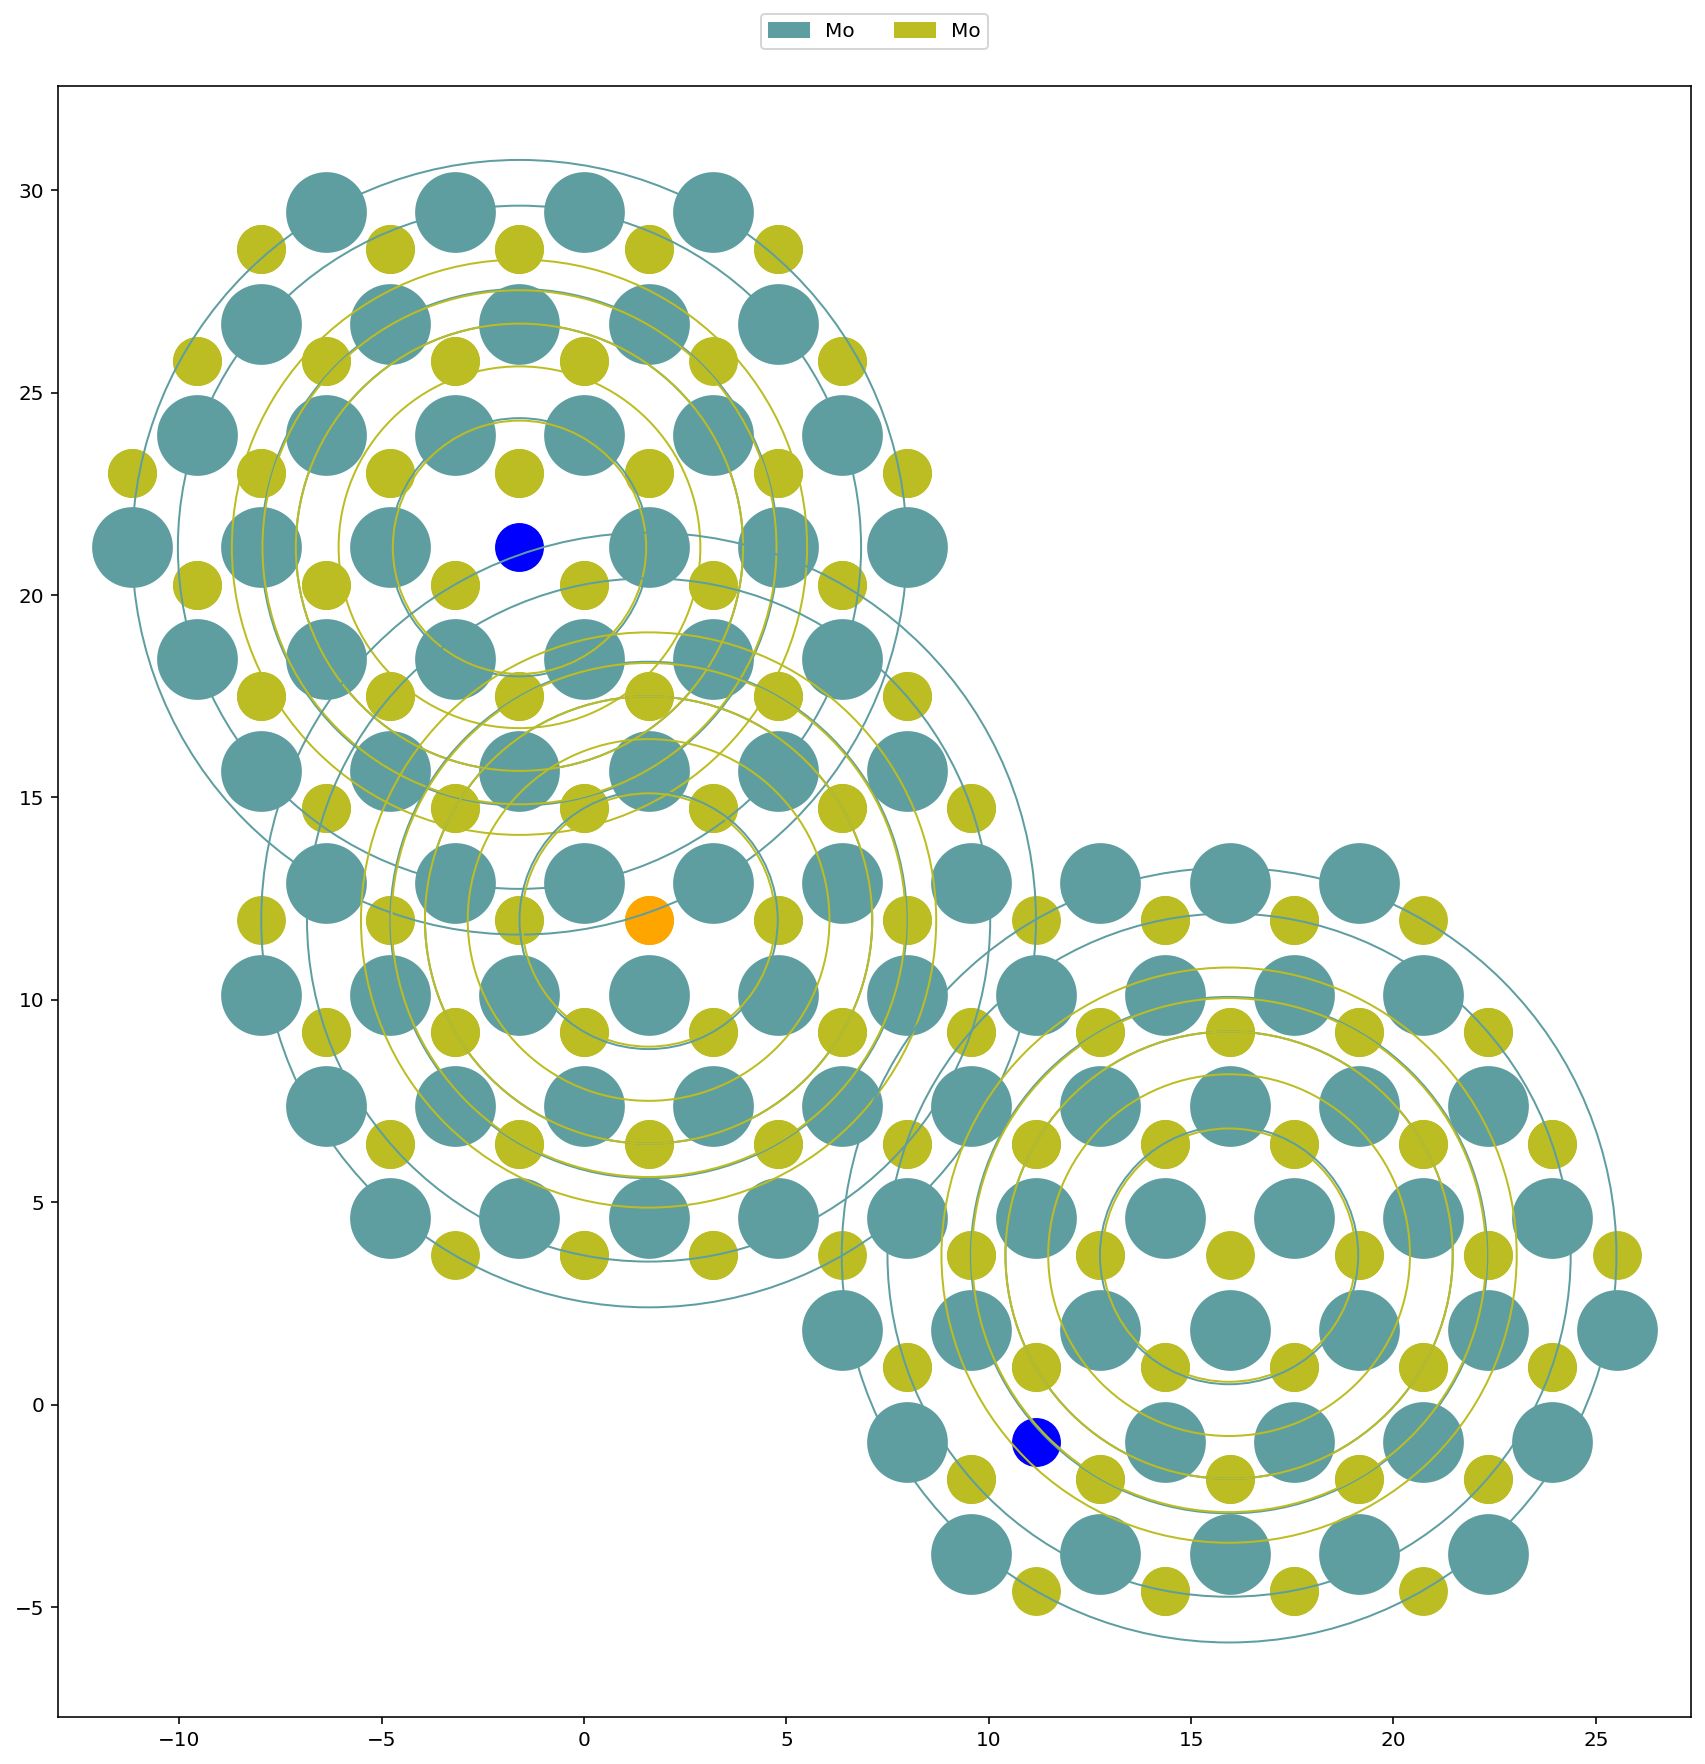

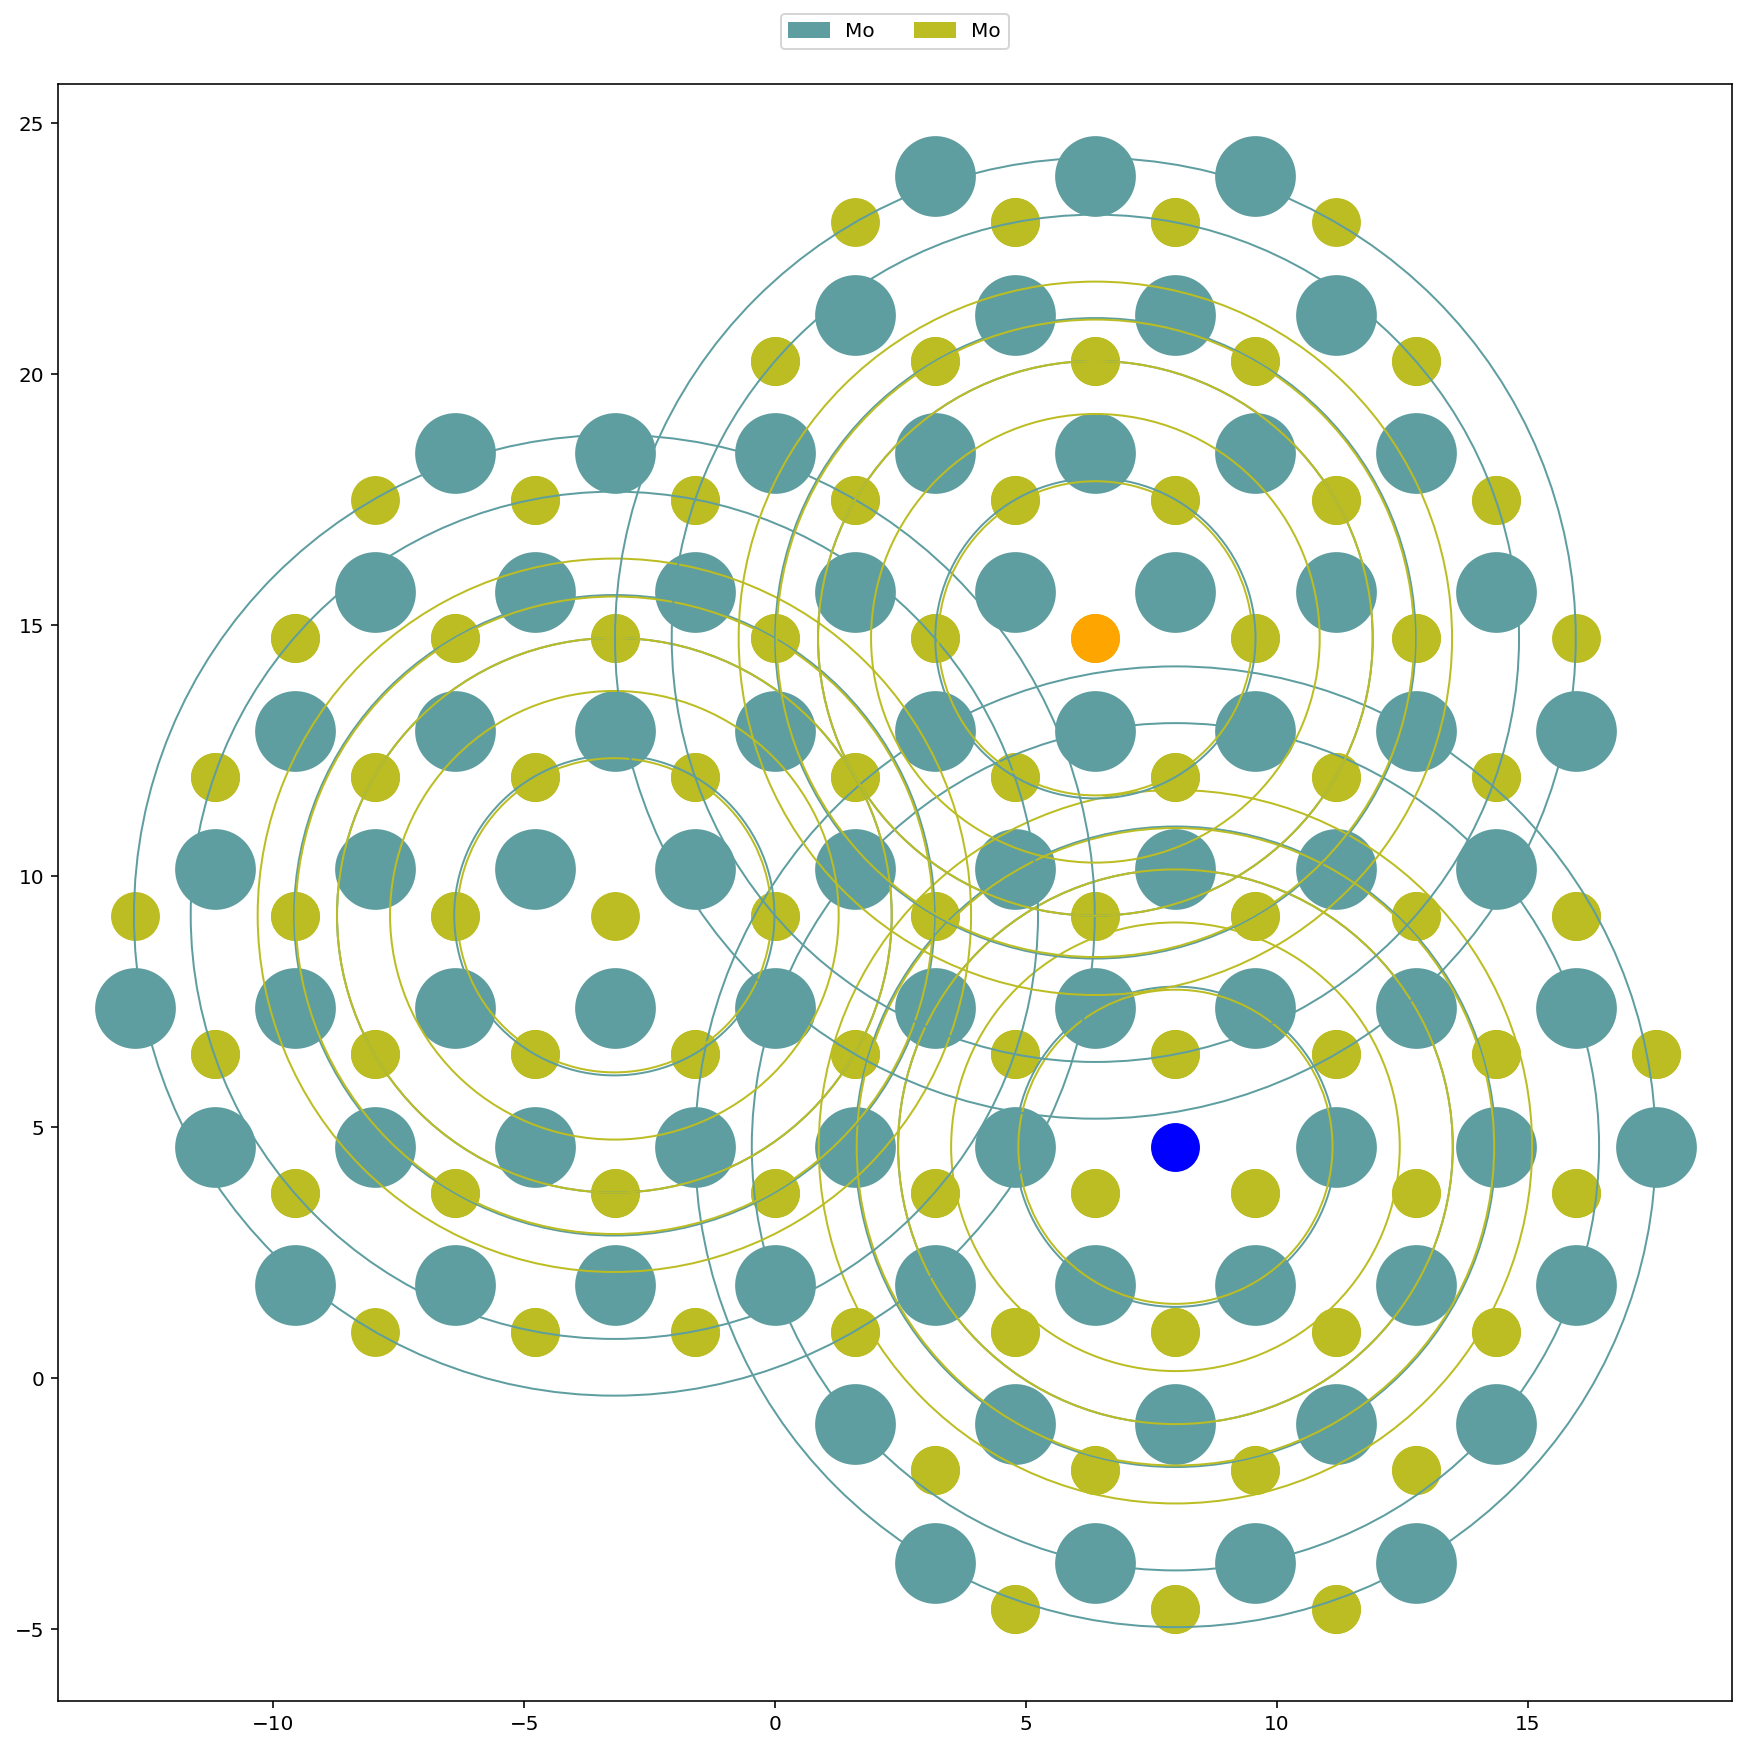

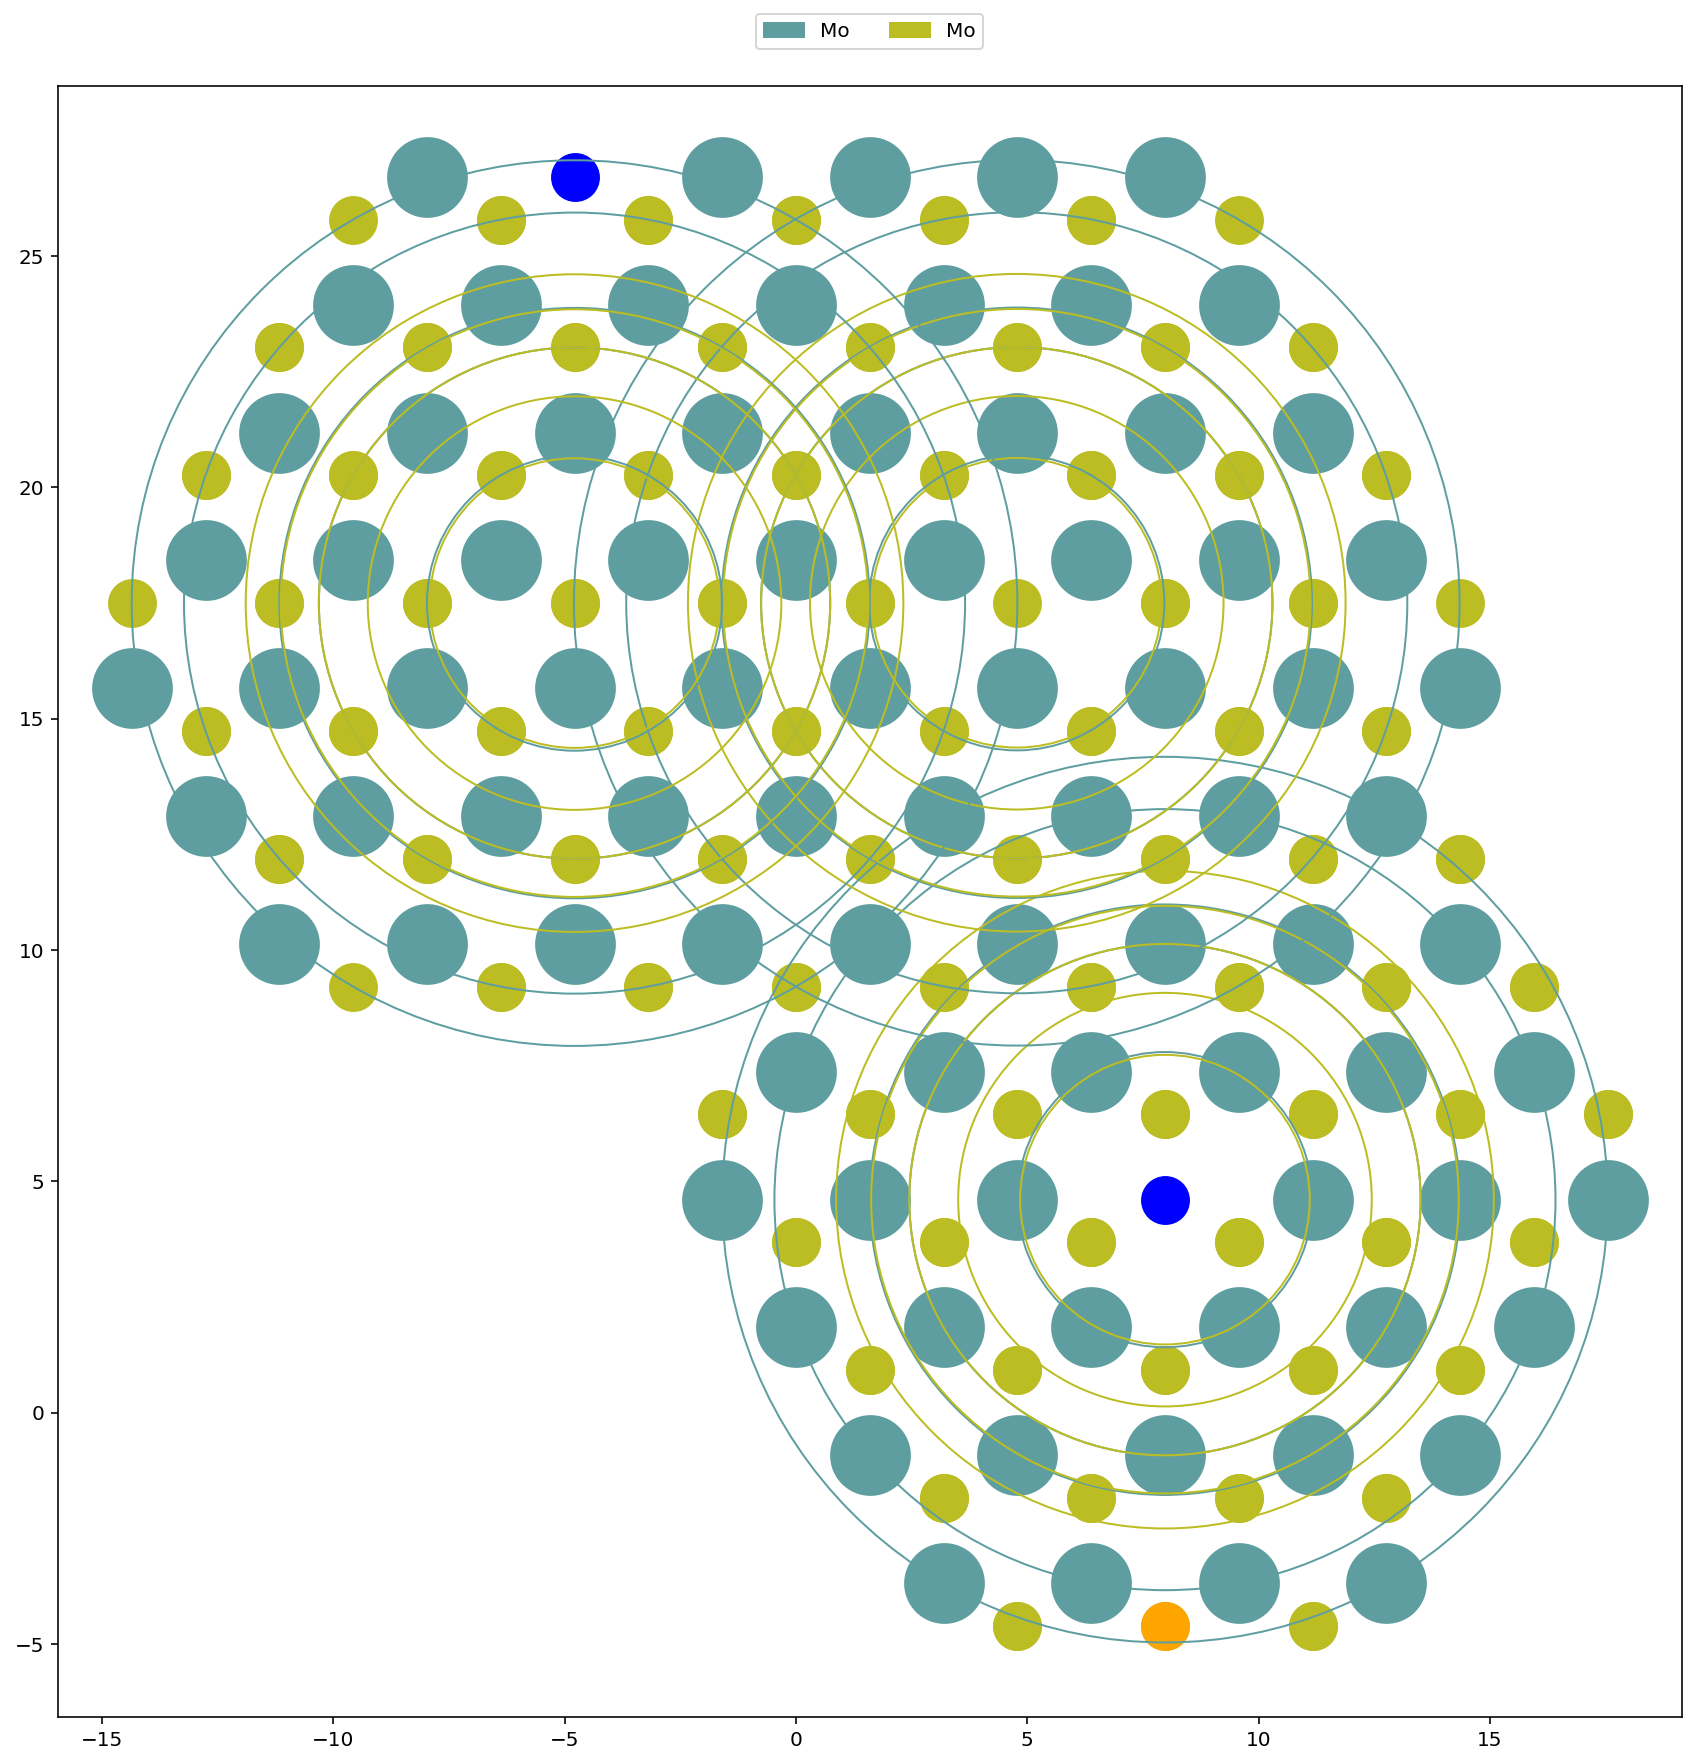

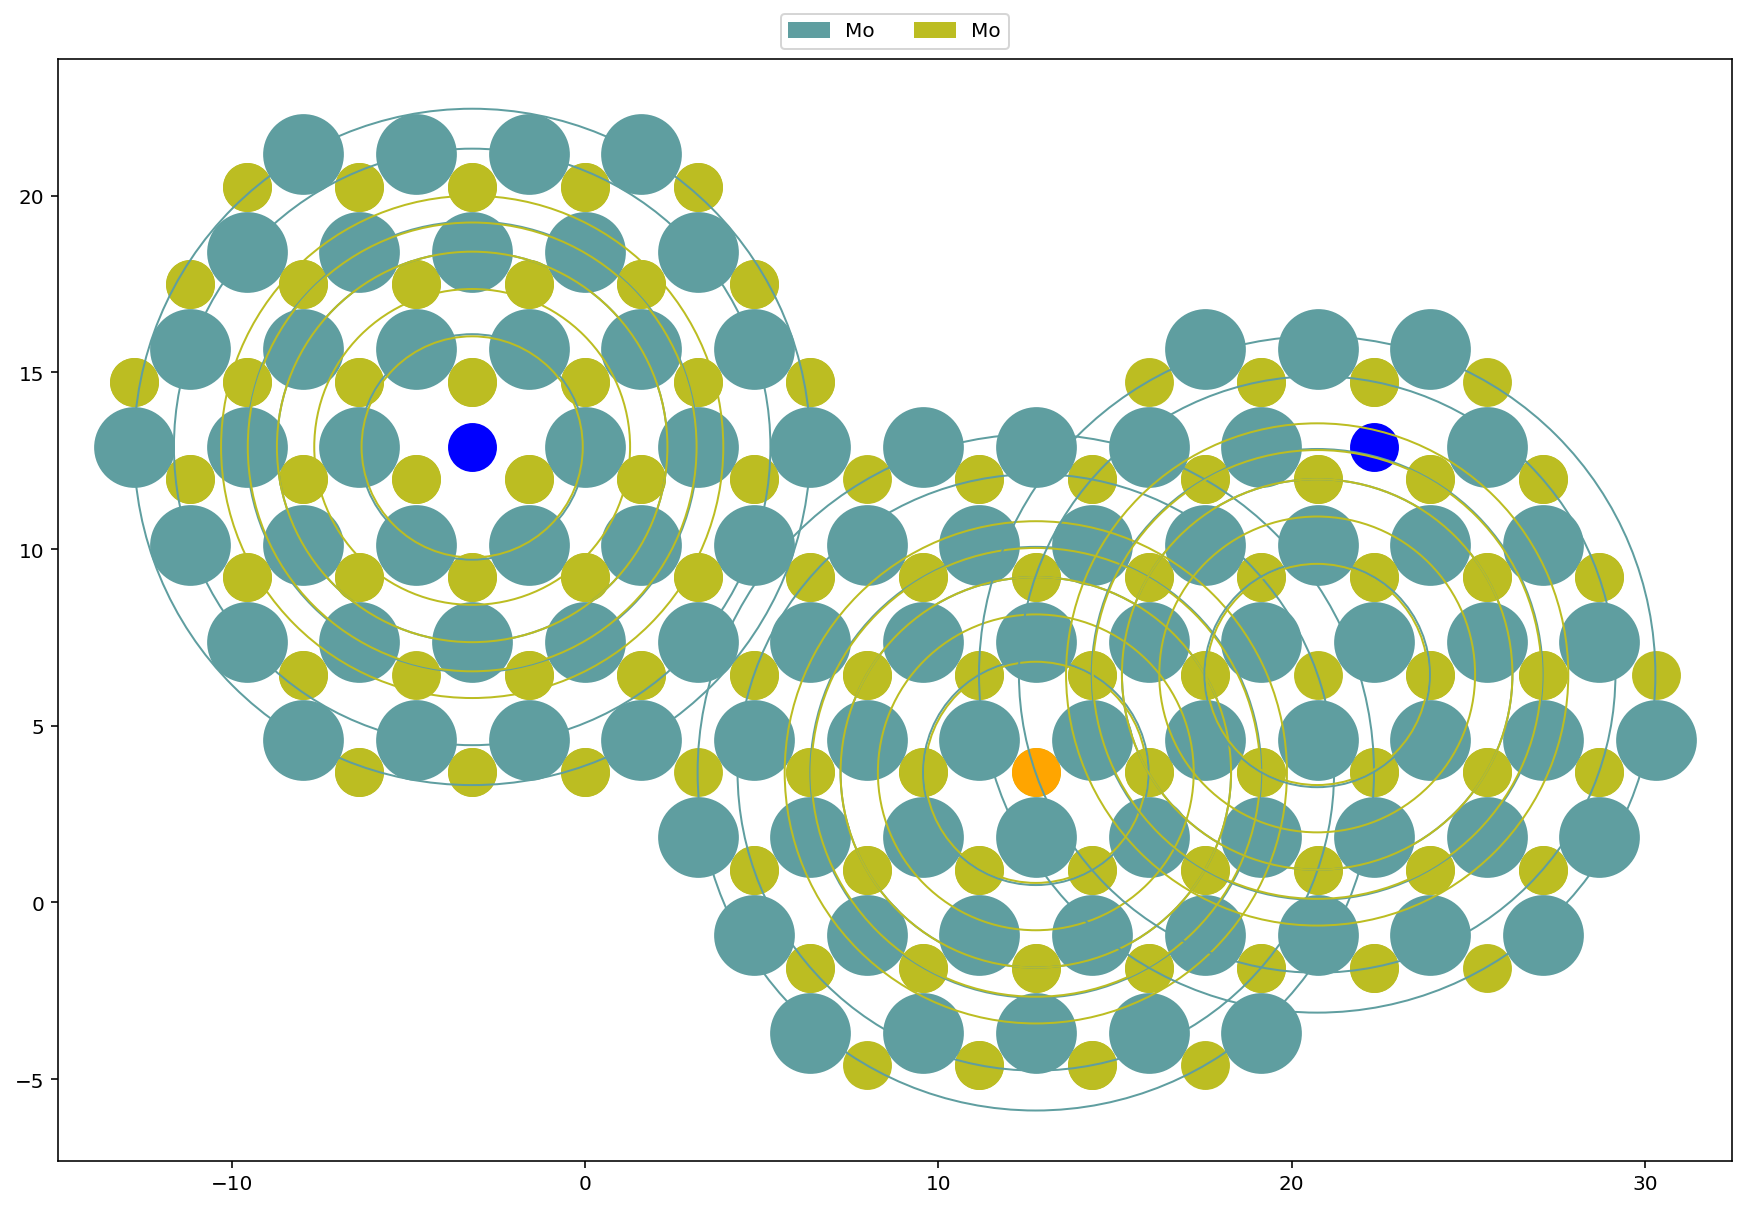

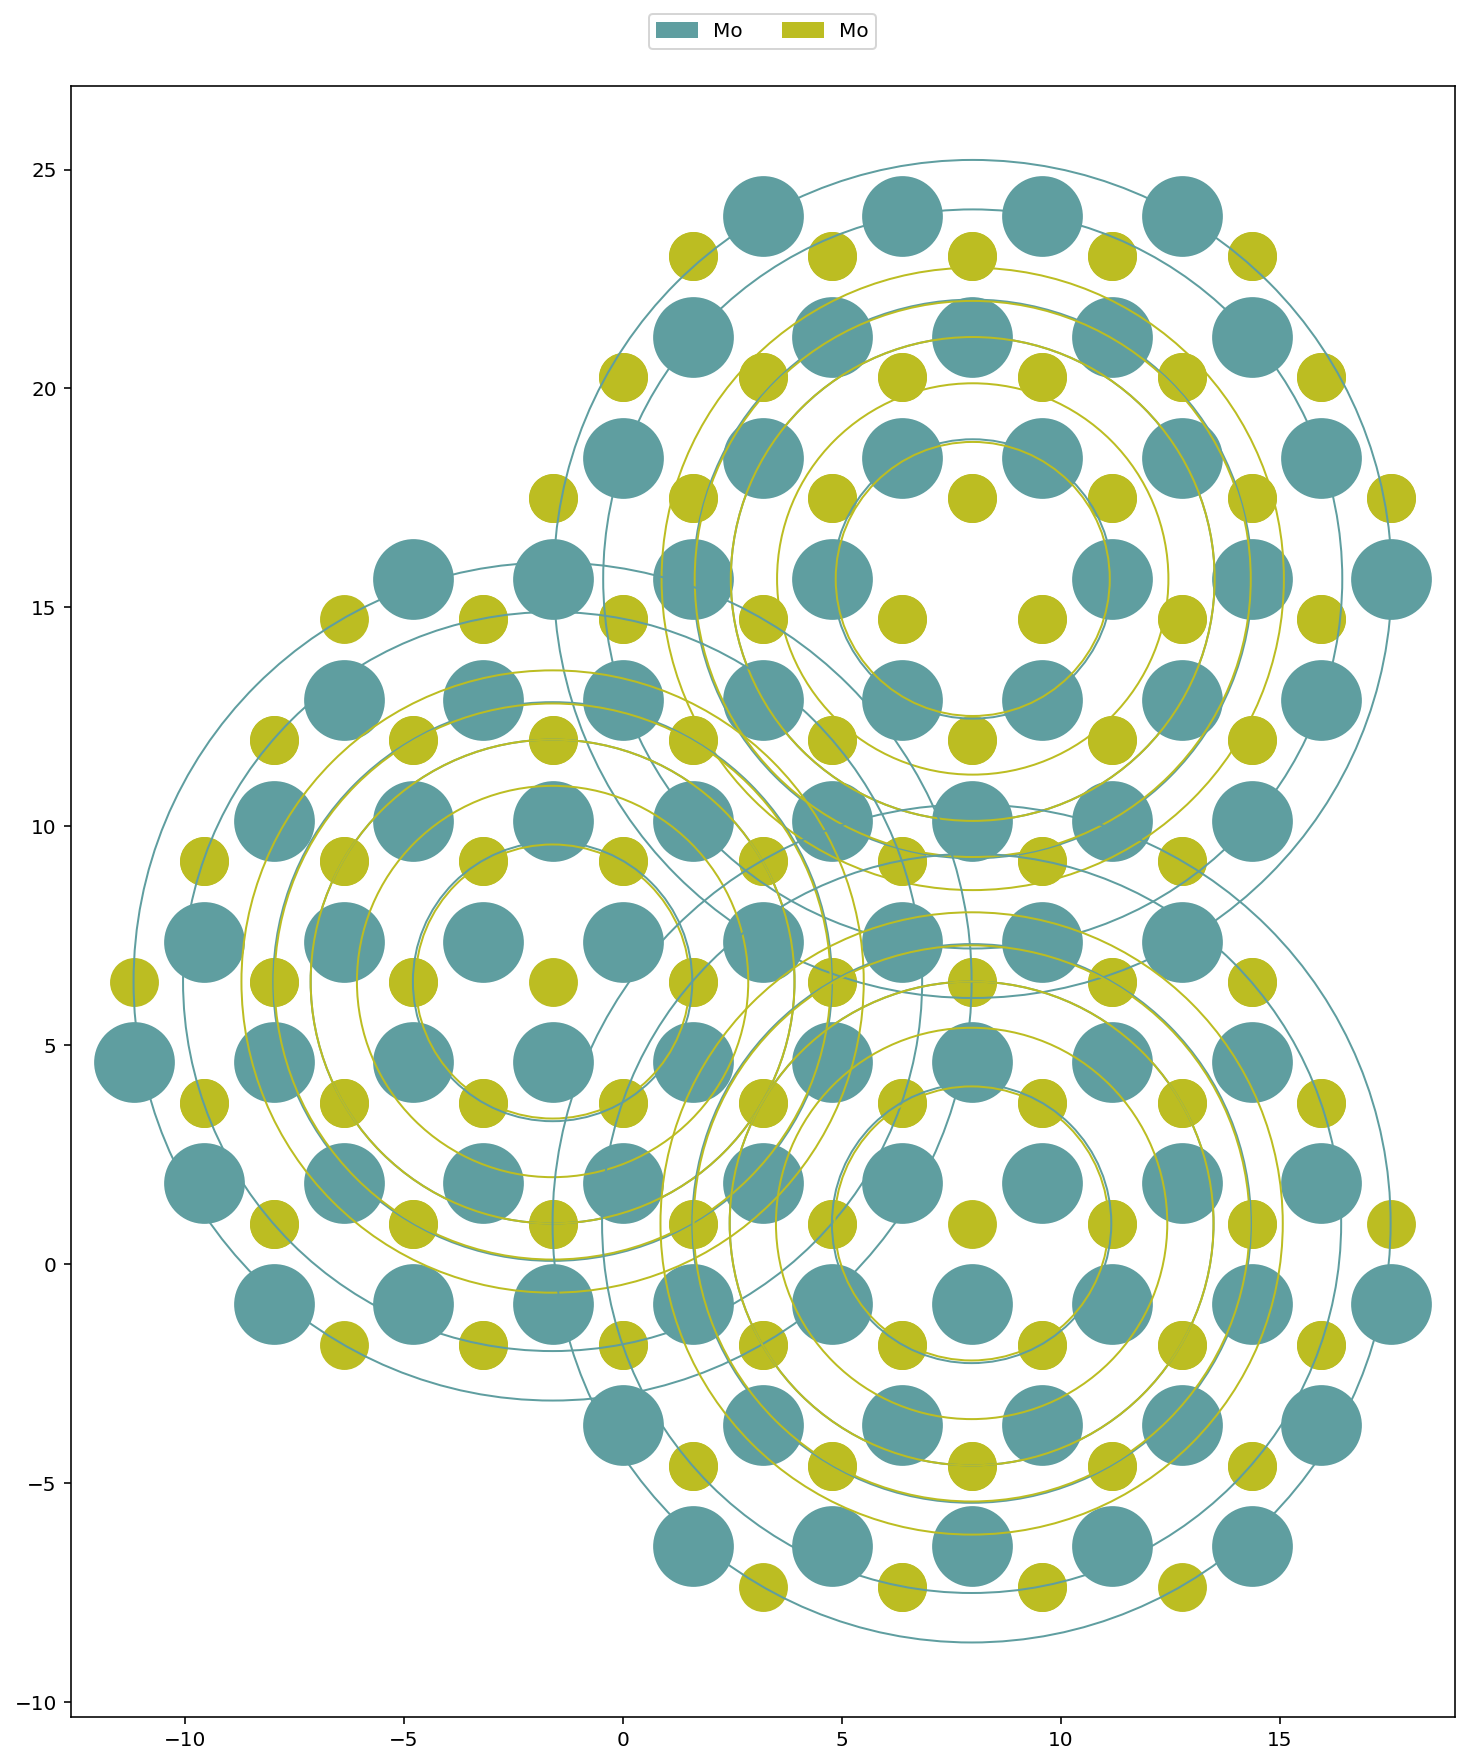

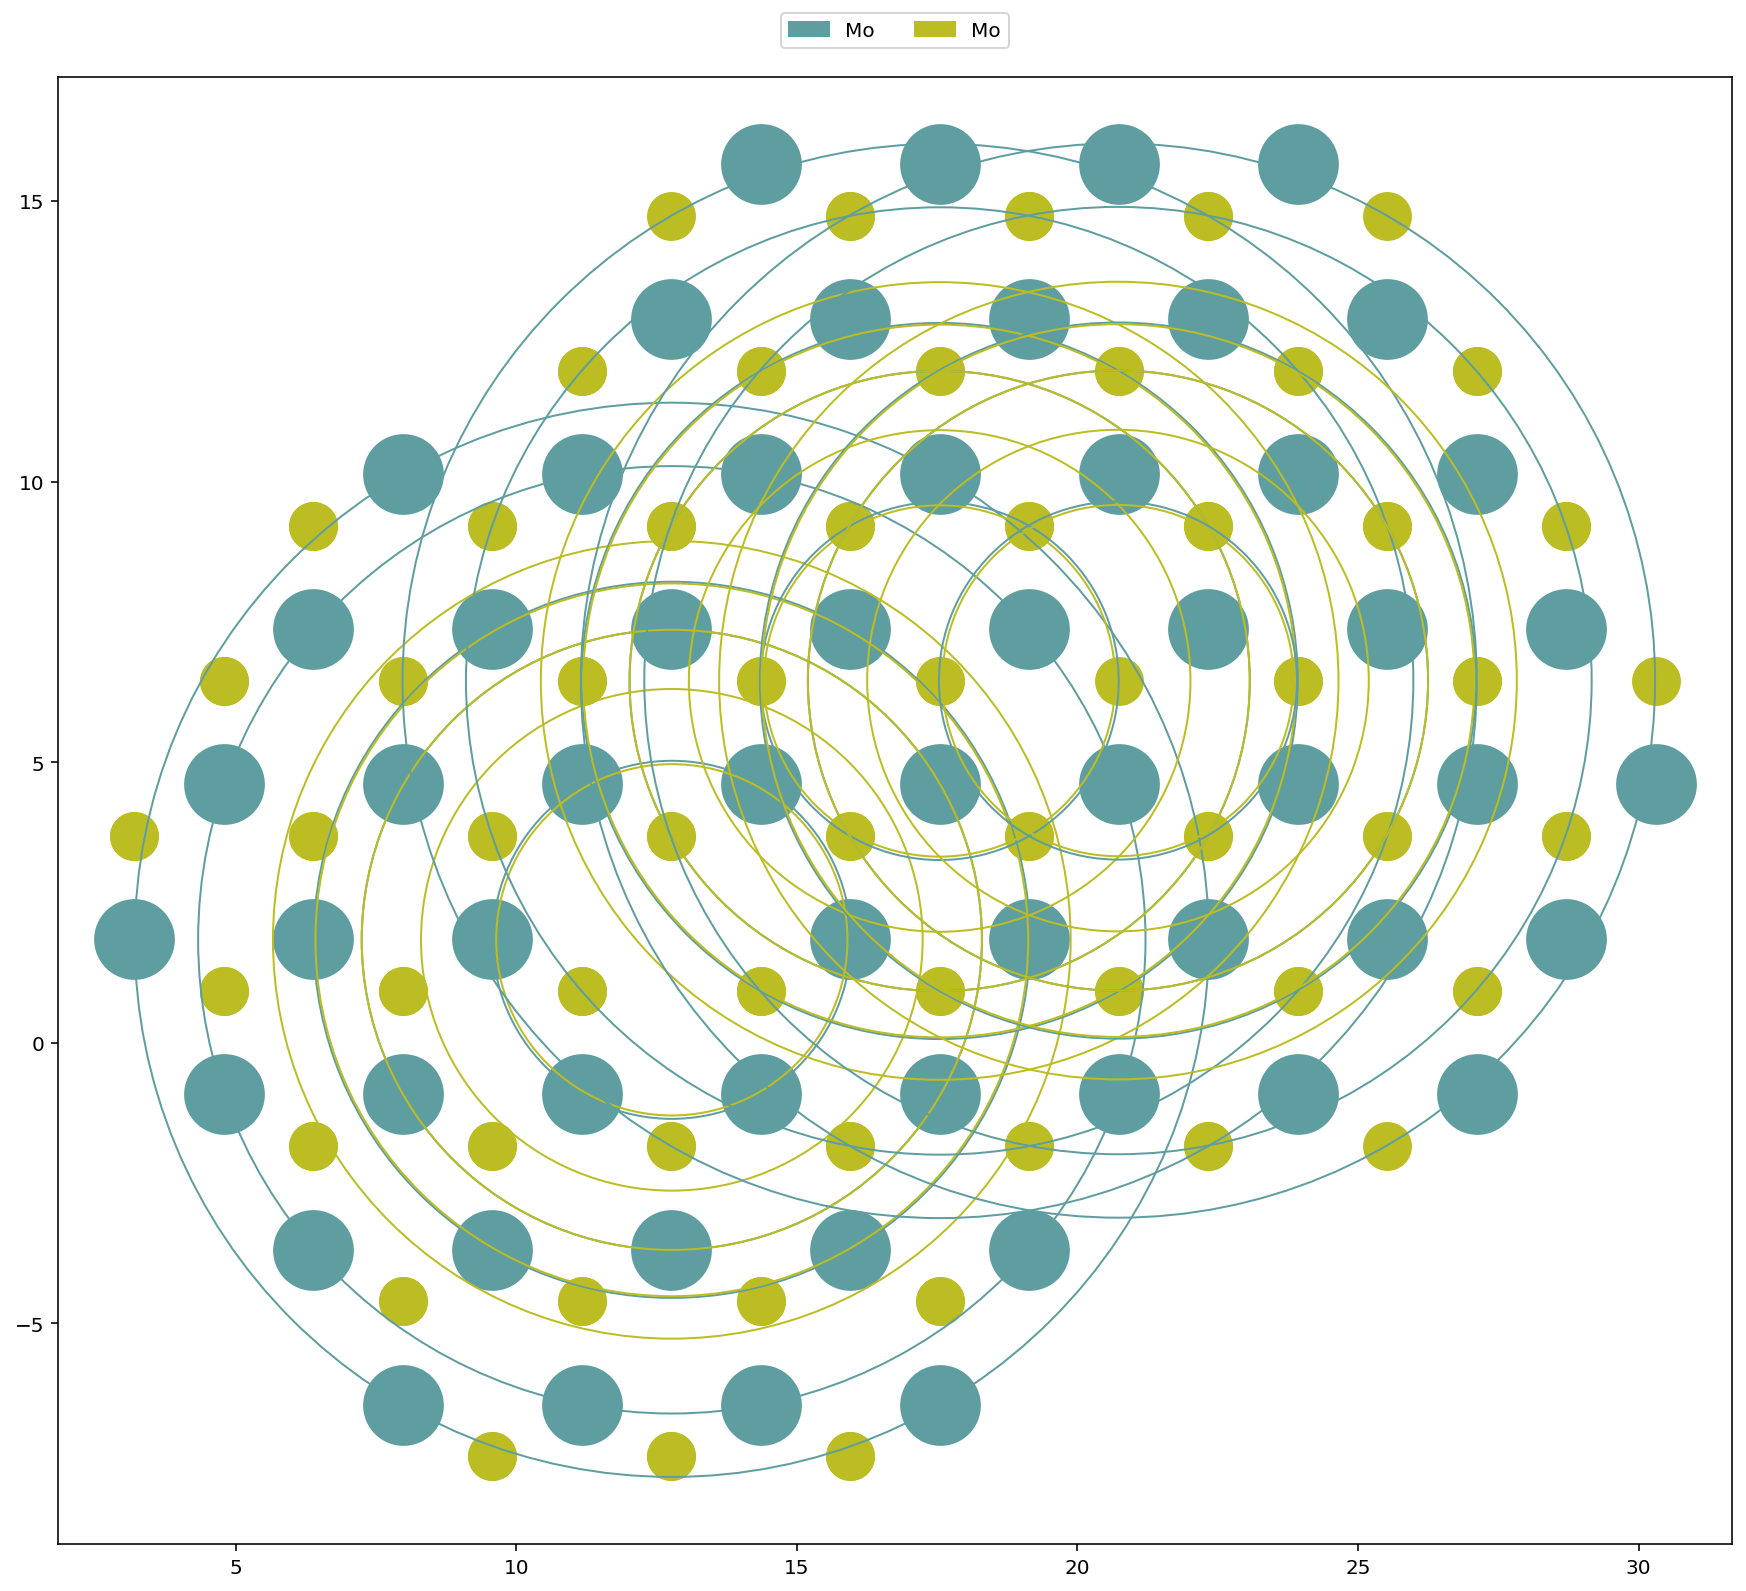

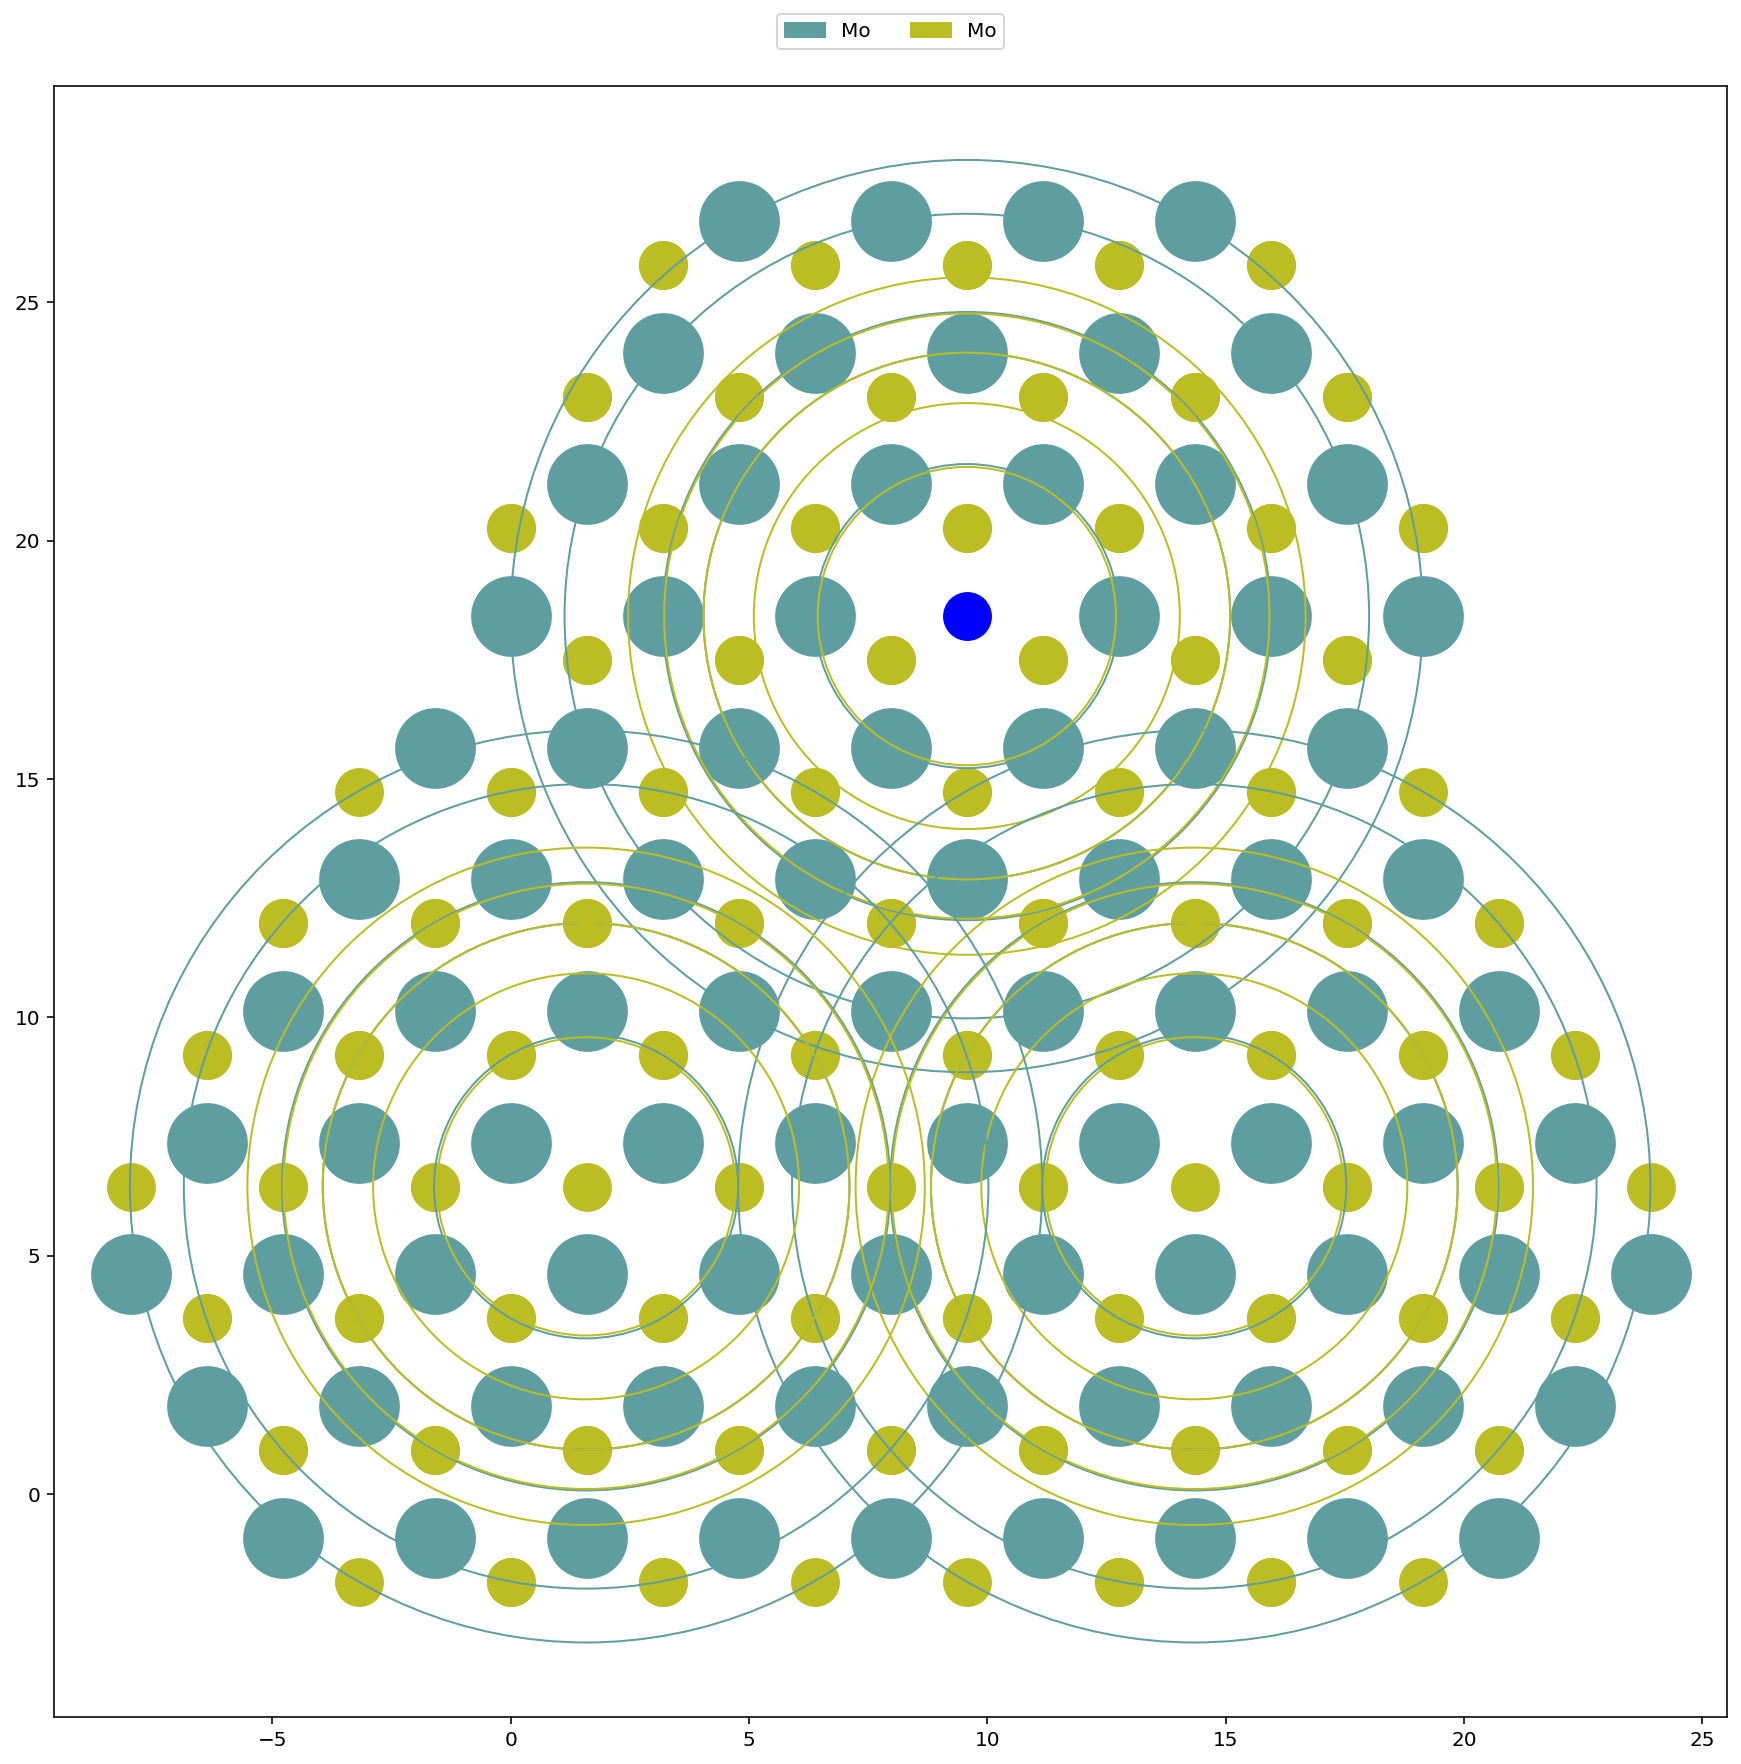

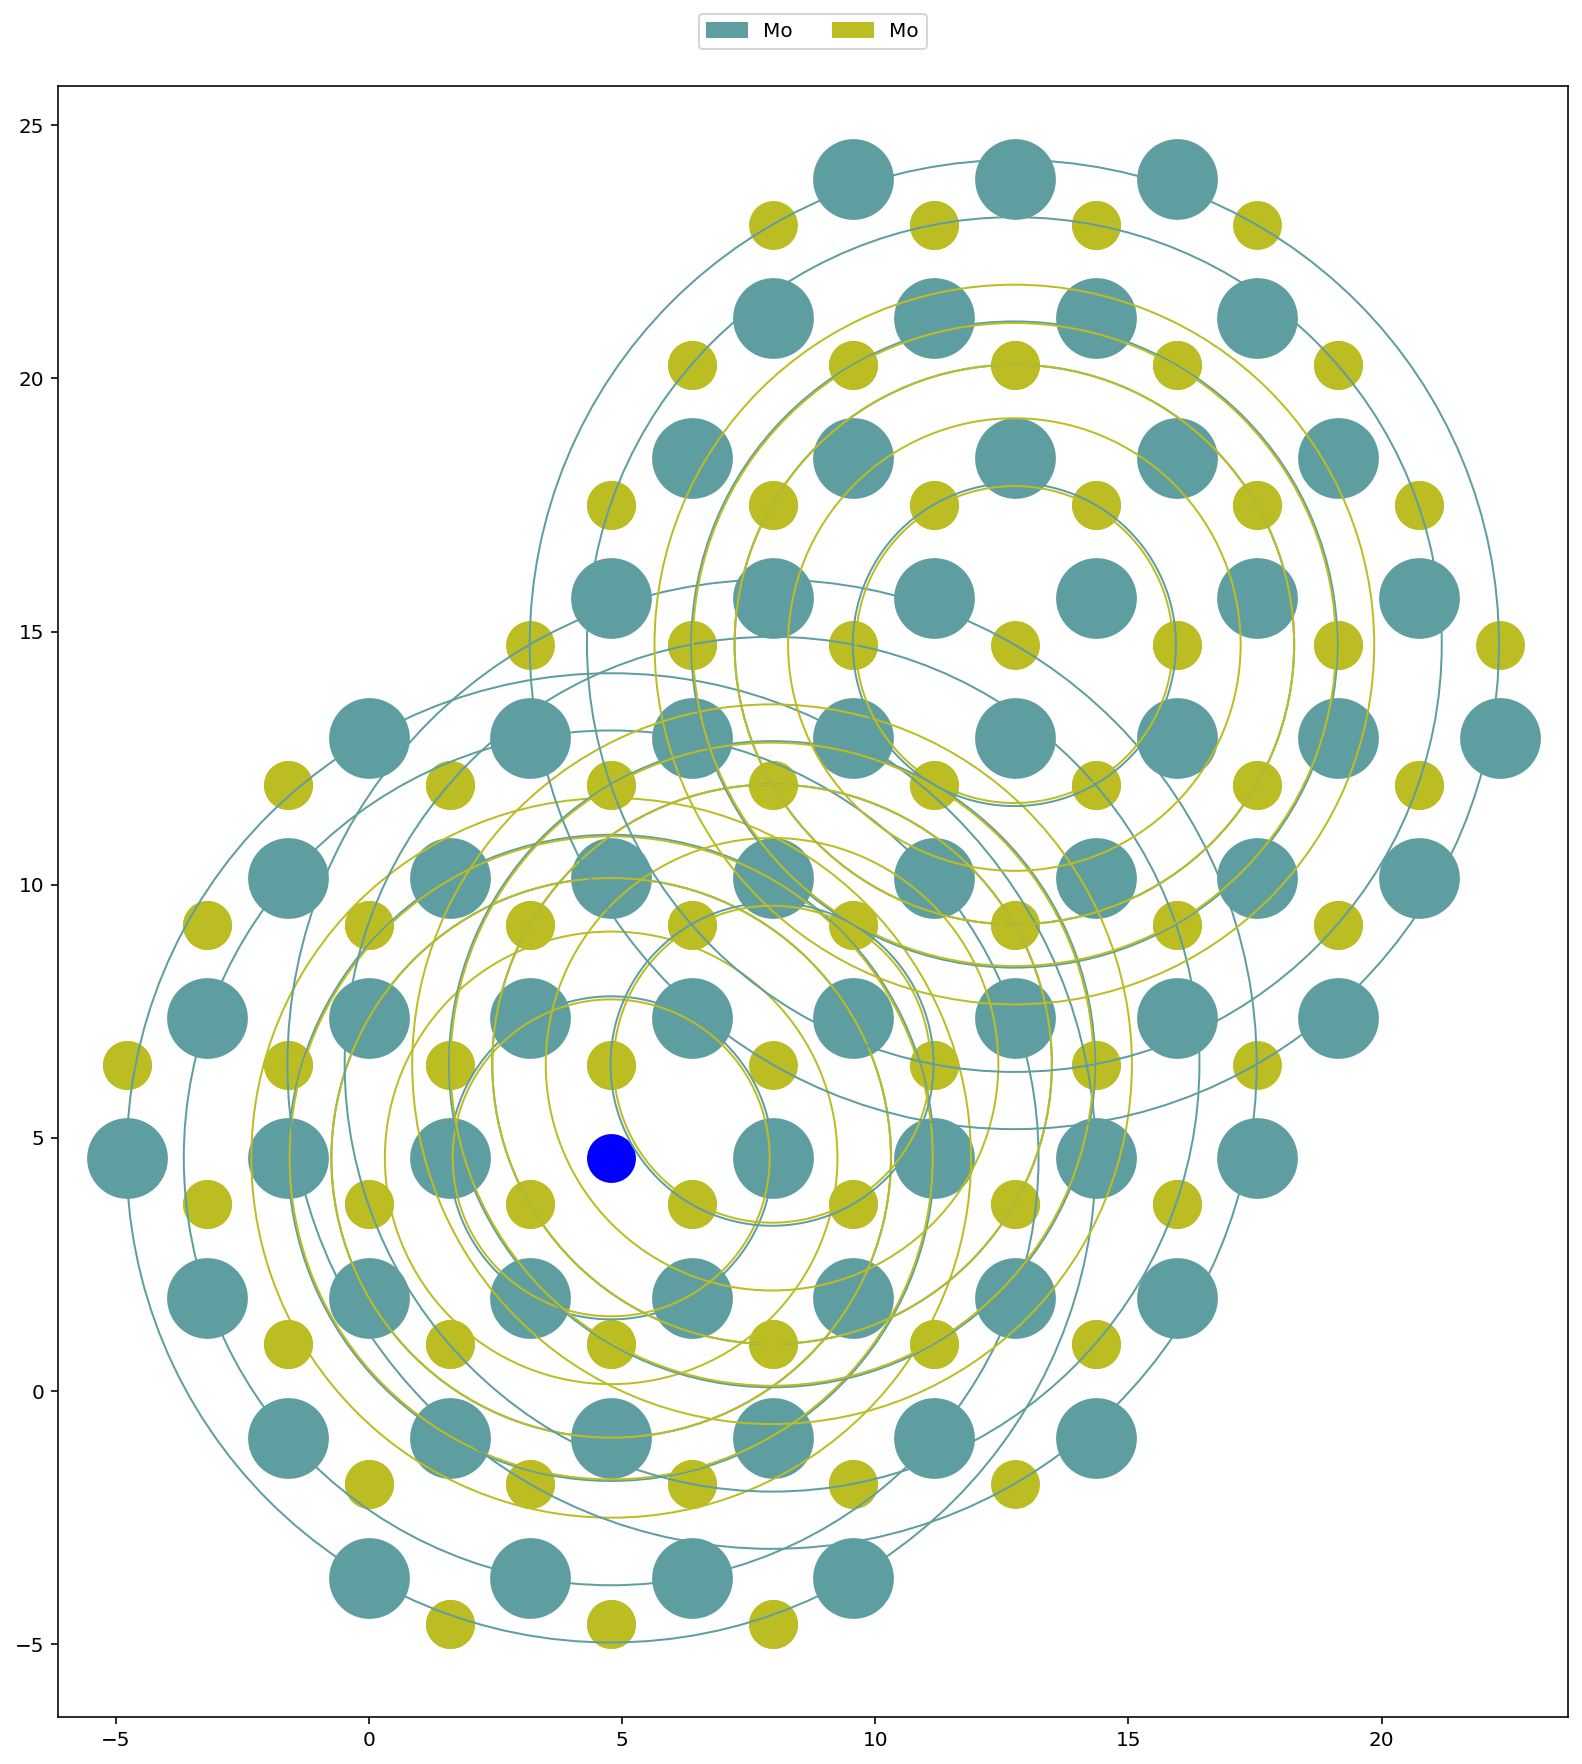

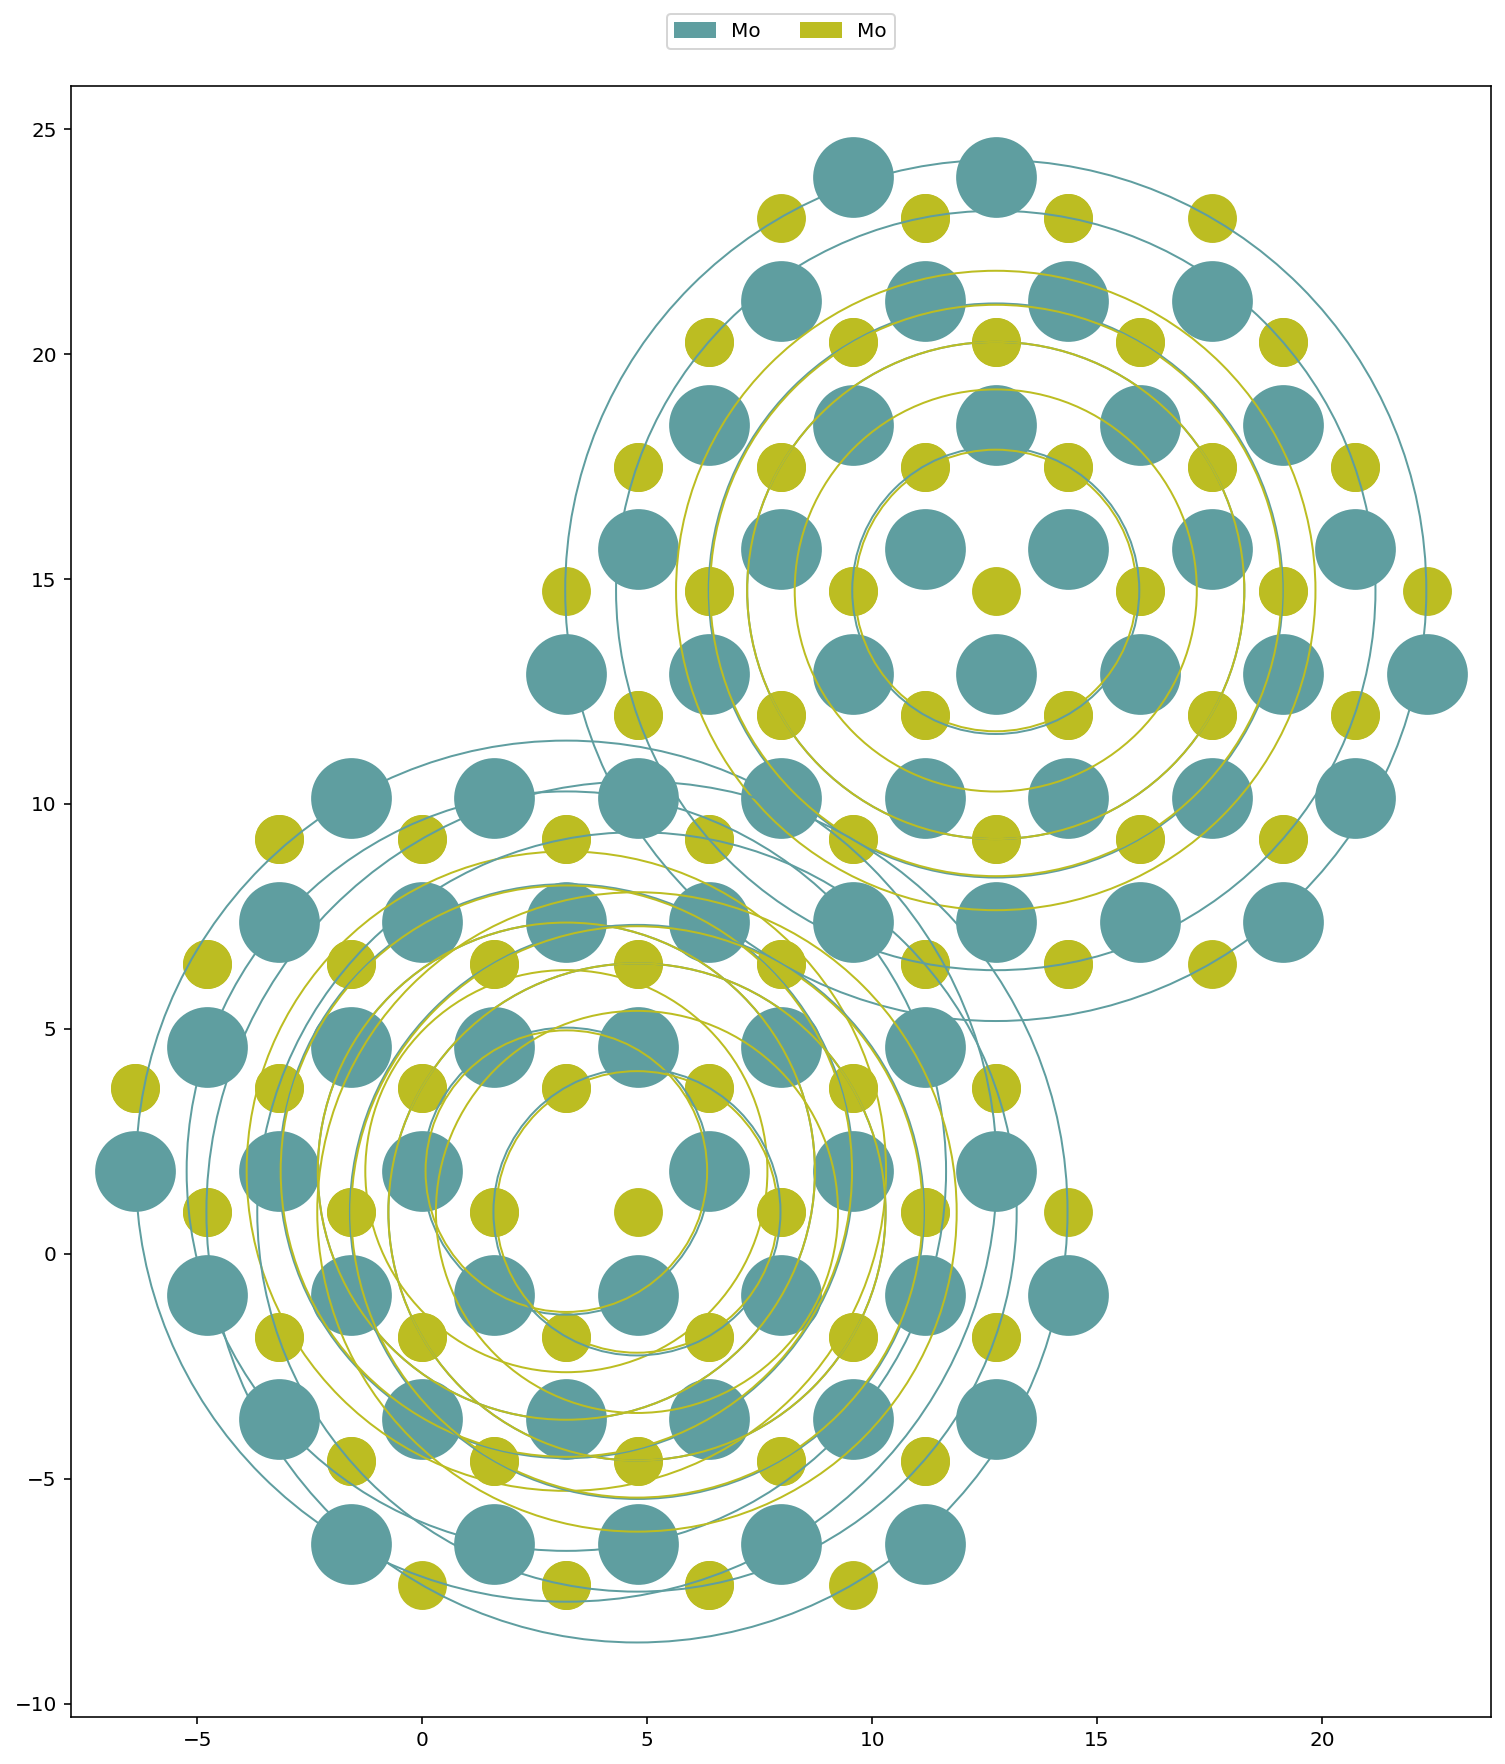

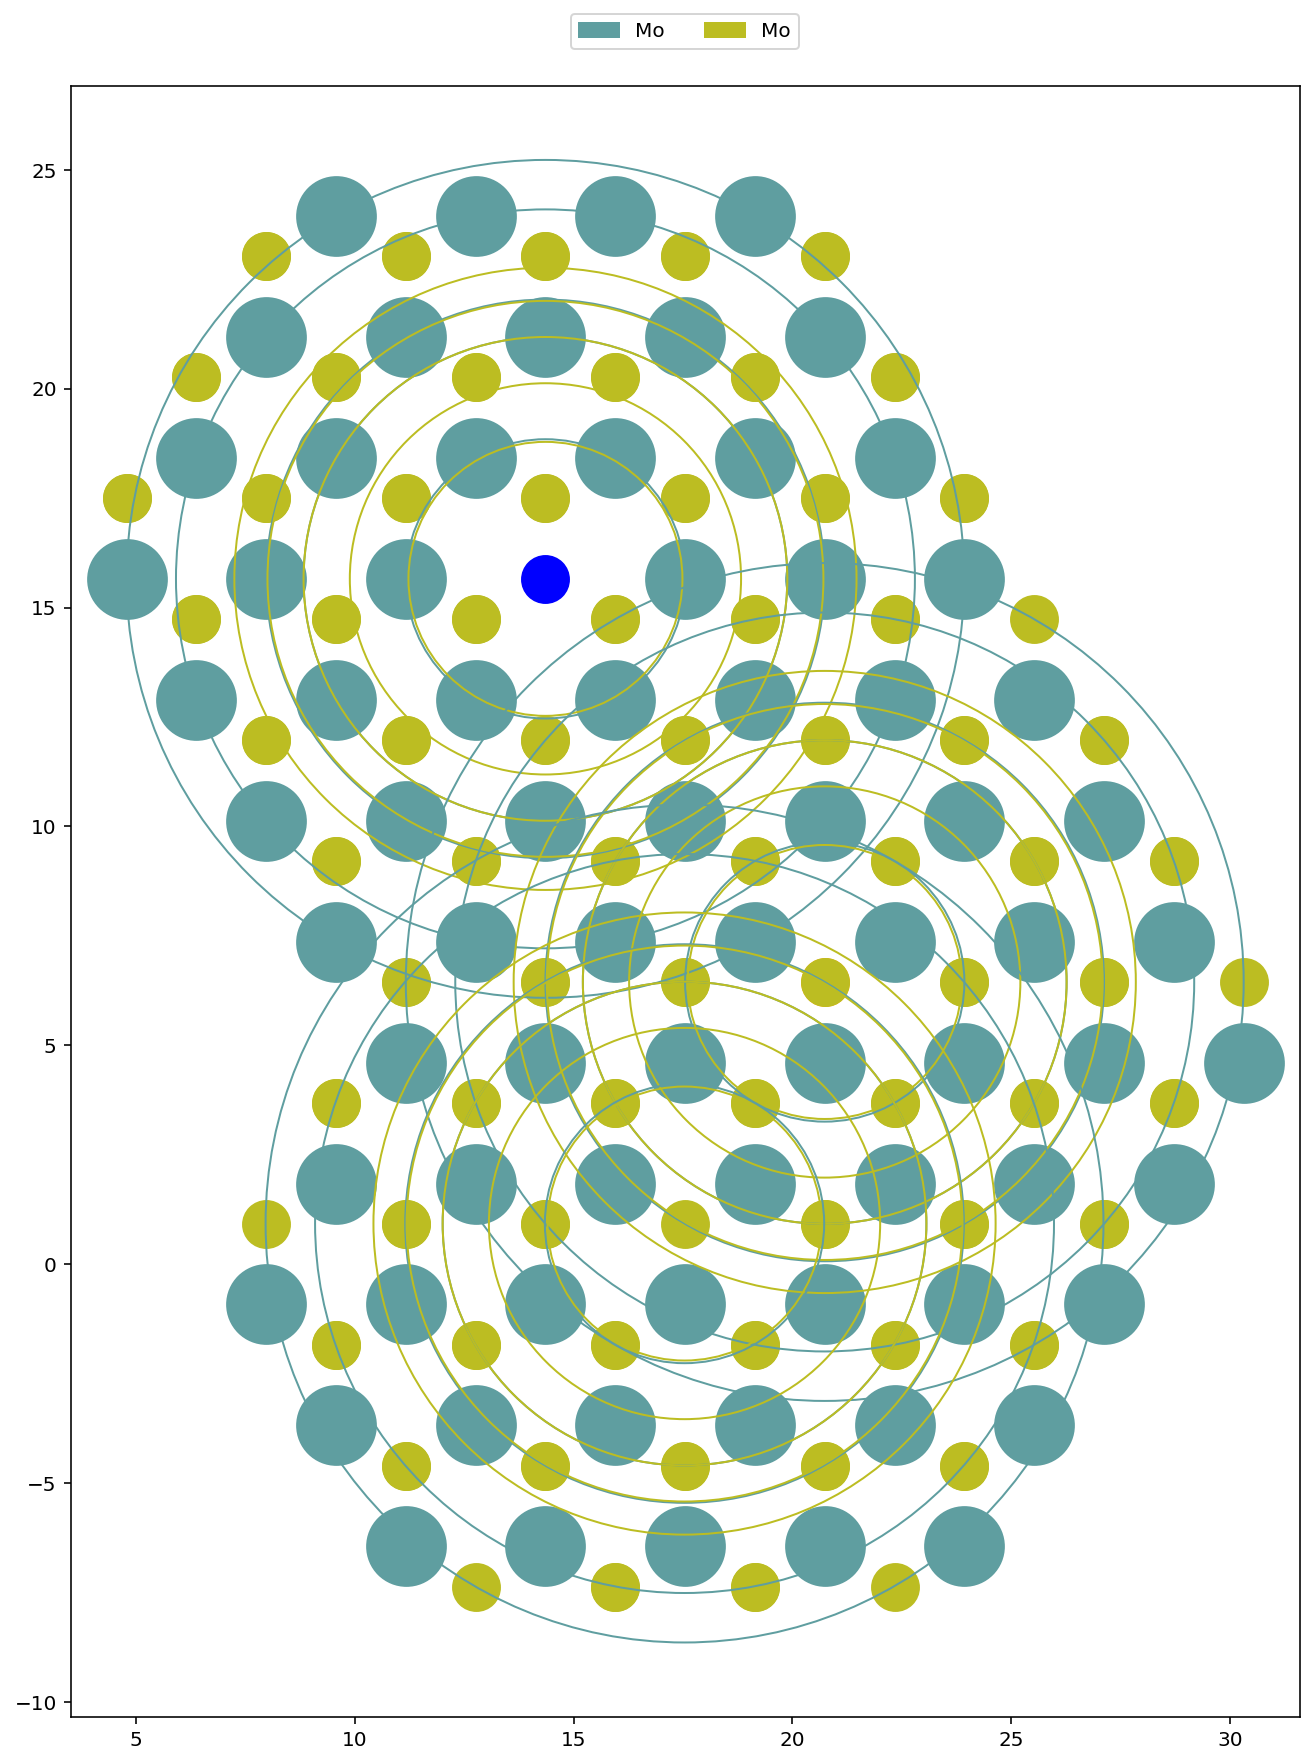

In [12]:
for i, row in data.sample(10).iterrows():
    # display(row.initial_structure)
    # new, spheres, sites = atoms_within_shell(row.initial_structure, row.defect_representation)
    struct = get_atoms_with_sphere(row.initial_structure, row.defect_representation, r=10)
    print('num_atoms in new:', struct.__len__())
    plot_shells(struct, row.defect_representation, Mo_r, S_r)

We can clearly see that the miss alignmnet between some of the atom types and the circles